In [4]:
# Import libraries
import os
import pandas as pd
import numpy as np
import requests
import yfinance as yf
from datetime import datetime, timedelta
import time
import json
from pathlib import Path
from dotenv import load_dotenv
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [6]:
# Load environment variables from .env file
load_dotenv()

# Get API token
EODHD_API_TOKEN = os.getenv('EODHD_API_TOKEN')

# EODHD API configuration
EODHD_BASE_URL = 'https://eodhd.com/api/mp/unicornbay/spglobal'

# Setup directory paths
BASE_DIR = Path.cwd().parent  # Goes up one level from notebooks/
DATA_DIR = BASE_DIR / 'data'
RAW_DIR = DATA_DIR / 'raw'
INDICES_DIR = RAW_DIR / 'indices'
PRICES_DIR = RAW_DIR / 'prices'
FUNDAMENTALS_DIR = RAW_DIR / 'fundamentals'

# Create directories if they don't exist
for dir_path in [INDICES_DIR, PRICES_DIR, FUNDAMENTALS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Verify setup
print(f"✅ Environment loaded")
print(f"✅ API Token (last 4 chars): ...{EODHD_API_TOKEN[-4:] if EODHD_API_TOKEN else '❌ NOT FOUND!'}")
print(f"✅ Data directory: {DATA_DIR}")
print(f"✅ Working directory: {Path.cwd()}")

✅ Environment loaded
✅ API Token (last 4 chars): ...0207
✅ Data directory: c:\Users\Windows\Desktop\Coding\git-nonocho\index-dashboard\data
✅ Working directory: c:\Users\Windows\Desktop\Coding\git-nonocho\index-dashboard\notebooks


In [7]:
# Quick test of EODHD API
def test_eodhd_connection():
    """Test if EODHD API is accessible with your token."""
    url = f"{EODHD_BASE_URL}/list"
    params = {'api_token': EODHD_API_TOKEN}
    
    print("🔍 Testing EODHD API connection...")
    
    try:
        response = requests.get(url, params=params, timeout=10)
        
        if response.status_code == 200:
            print(f"✅ SUCCESS! API is working.")
            print(f"✅ Response size: {len(response.text)} characters")
            return True
        else:
            print(f"❌ ERROR: Status code {response.status_code}")
            print(f"❌ Response: {response.text[:200]}")
            return False
            
    except Exception as e:
        print(f"❌ CONNECTION ERROR: {e}")
        return False

# Run the test
test_eodhd_connection()

🔍 Testing EODHD API connection...
✅ SUCCESS! API is working.
✅ Response size: 41777 characters


True

In [8]:
def fetch_indices_list():
    """
    Fetch list of all available S&P and DJ indices from EODHD.
    
    Returns:
        pd.DataFrame: DataFrame with index details
    """
    url = f"{EODHD_BASE_URL}/list"
    params = {'api_token': EODHD_API_TOKEN}
    
    print("📡 Fetching list of available indices...")
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data)
        print(f"✅ Retrieved {len(df)} indices")
        return df
    else:
        print(f"❌ Error {response.status_code}: {response.text}")
        return None

# Fetch the indices
indices_df = fetch_indices_list()

# Display the data
if indices_df is not None:
    print("\n📊 First 10 indices:")
    display(indices_df.head(10))
    
    # Show data types and columns
    print("\n📋 Column information:")
    print(indices_df.info())

📡 Fetching list of available indices...
✅ Retrieved 110 indices

📊 First 10 indices:


,ID,Code,Name,Constituents,Value,MarketCap,Divisor,DailyReturn,Dividend,AdjustedMarketCap,AdjustedDivisor,AdjustedConstituents,CurrencyCode,CurrencyName,CurrencySymbol,LastUpdate
0,SPSIADIN.INDX,SPSIADIN,S&P Aerospace & Defense Select Industry Index ...,40,35584.9909,NaN,NaN,-0.0030,NaN,NaN,NaN,40,ILS,Israeli new shekel,₪,2025-10-07
1,SPSIADIP.INDX,SPSIADIP,S&P Aerospace & Defense Select Industry Index ...,40,29743.8081,3.688300e+10,1.240023e+06,-0.0030,NaN,3.688300e+10,1.240023e+06,40,ILS,Israeli new shekel,₪,2025-10-07
2,SPSIADIT.INDX,SPSIADIT,S&P Aerospace & Defense Select Industry Index ...,40,38426.7343,NaN,NaN,-0.0030,NaN,NaN,NaN,40,ILS,Israeli new shekel,₪,2025-10-07
3,SPSIAHIN.INDX,SPSIAHIN,S&P Aerospace & Defense Select Industry ILS He...,40,15722.4359,NaN,NaN,-0.0043,NaN,NaN,NaN,40,ILS,Israeli new shekel,₪,2025-10-07
4,SPSIAHIP.INDX,SPSIAHIP,S&P Aerospace & Defense Select Industry ILS He...,40,13613.8864,NaN,NaN,-0.0043,NaN,NaN,NaN,40,ILS,Israeli new shekel,₪,2025-10-07
5,SPSIAHIT.INDX,SPSIAHIT,S&P Aerospace & Defense Select Industry ILS He...,40,16723.0845,NaN,NaN,-0.0043,NaN,NaN,NaN,40,ILS,Israeli new shekel,₪,2025-10-07
6,SPSIHHIN.INDX,SPSIHHIN,S&P Homebuilders Select Industry ILS Hedged In...,35,2055.6909,NaN,NaN,-0.0252,NaN,NaN,NaN,35,ILS,Israeli new shekel,₪,2025-10-07
7,SPSIHHIP.INDX,SPSIHHIP,S&P Homebuilders Select Industry ILS Hedged Index,35,1750.0379,NaN,NaN,-0.0252,NaN,NaN,NaN,35,ILS,Israeli new shekel,₪,2025-10-07
8,SPSIHHIT.INDX,SPSIHHIT,S&P Homebuilders Select Industry ILS Hedged In...,35,2202.2704,NaN,NaN,-0.0252,NaN,NaN,NaN,35,ILS,Israeli new shekel,₪,2025-10-07
9,SPSIHOIN.INDX,SPSIHOIN,S&P Homebuilders Select Industry Index (ILS) NTR,35,10124.7502,NaN,NaN,-0.0239,NaN,NaN,NaN,35,ILS,Israeli new shekel,₪,2025-10-07



📋 Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    110 non-null    object 
 1   Code                  110 non-null    object 
 2   Name                  110 non-null    object 
 3   Constituents          110 non-null    int64  
 4   Value                 110 non-null    float64
 5   MarketCap             38 non-null     float64
 6   Divisor               38 non-null     float64
 7   DailyReturn           110 non-null    float64
 8   Dividend              12 non-null     float64
 9   AdjustedMarketCap     38 non-null     float64
 10  AdjustedDivisor       38 non-null     float64
 11  AdjustedConstituents  110 non-null    int64  
 12  CurrencyCode          110 non-null    object 
 13  CurrencyName          110 non-null    object 
 14  CurrencySymbol        110 non-null    object 
 15  

In [9]:
if indices_df is not None:
    
    # Show summary statistics
    print("📊 Summary Statistics:")
    print(f"Total indices available: {len(indices_df)}")
    print(f"Average constituents: {indices_df['Constituents'].mean():.1f}")
    print(f"Largest index: {indices_df.loc[indices_df['Constituents'].idxmax(), 'Name']}")
    print(f"Total market cap (all indices): ${indices_df['MarketCap'].sum()/1e12:.2f} Trillion")
    
    # Filter for major S&P indices we care about
    print("\n🎯 Major S&P Indices:")
    major_codes = ['GSPC', 'OEX', 'SP400', 'SP600']
    sp_indices = indices_df[indices_df['Code'].isin(major_codes)]
    
    if len(sp_indices) > 0:
        # Display key columns only
        display(sp_indices[['Code', 'Name', 'Constituents', 'MarketCap', 'LastUpdate']])
    else:
        print("⚠️ Major S&P indices not found. Available codes:")
        print(indices_df['Code'].unique()[:20])

📊 Summary Statistics:
Total indices available: 110
Average constituents: 94.8
Largest index: S&P Composite 1500
Total market cap (all indices): $230.28 Trillion

🎯 Major S&P Indices:


,Code,Name,Constituents,MarketCap,LastUpdate
14,OEX,S&P 100,101,4.134100e+13,2025-10-07
15,GSPC,S&P 500,503,5.726980e+13,2025-10-07


In [10]:
# Save the full indices list for reference
if indices_df is not None:
    output_file = INDICES_DIR / 'available_indices_list.csv'
    indices_df.to_csv(output_file, index=False)
    print(f"💾 Saved indices list to: {output_file}")
    print(f"📁 File size: {output_file.stat().st_size / 1024:.2f} KB")

💾 Saved indices list to: c:\Users\Windows\Desktop\Coding\git-nonocho\index-dashboard\data\raw\indices\available_indices_list.csv
📁 File size: 15.23 KB


In [11]:
def fetch_index_constituents(index_code):
    """
    Fetch current constituents and historical changes for an index.
    
    Args:
        index_code: Index symbol (e.g., 'GSPC.INDX' for S&P 500)
    
    Returns:
        tuple: (constituents_df, historical_df, metadata_dict)
    """
    url = f"{EODHD_BASE_URL}/comp/{index_code}"
    params = {
        'api_token': EODHD_API_TOKEN,
        'fmt': 'json'
    }
    
    print(f"\n📡 Fetching constituents for {index_code}...")
    
    try:
        response = requests.get(url, params=params, timeout=30)
        
        if response.status_code != 200:
            print(f"❌ Error {response.status_code}: {response.text[:200]}")
            return None, None, None
        
        data = response.json()
        
        # 1. Extract general metadata
        general = data.get('General', {})
        metadata = {
            'IndexCode': index_code,
            'Name': general.get('Name'),
            'Type': general.get('Type'),
            'Exchange': general.get('Exchange'),
            'MarketCap': general.get('MarketCap'),
            'Currency': general.get('CurrencyCode'),
            'FetchDate': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        print(f"✅ Index: {metadata['Name']}")
        
        # 2. Extract current components
        components = data.get('Components', {})
        if components:
            constituents_df = pd.DataFrame.from_dict(components, orient='index')
            constituents_df = constituents_df.reset_index(drop=True)
            constituents_df['IndexCode'] = index_code
            constituents_df['AsOfDate'] = datetime.now().strftime('%Y-%m-%d')
            print(f"✅ Current constituents: {len(constituents_df)}")
        else:
            constituents_df = pd.DataFrame()
            print("⚠️  No current constituents found")
        
        # 3. Extract historical changes
        historical = data.get('HistoricalTickerComponents', {})
        if historical:
            historical_df = pd.DataFrame.from_dict(historical, orient='index')
            historical_df = historical_df.reset_index(drop=True)
            historical_df['IndexCode'] = index_code
            print(f"✅ Historical changes: {len(historical_df)} records")
            
            # Show date range of historical data
            if 'StartDate' in historical_df.columns:
                min_date = pd.to_datetime(historical_df['StartDate']).min()
                max_date = pd.to_datetime(historical_df['EndDate']).max()
                print(f"   └─ Date range: {min_date.date()} to {max_date.date()}")
        else:
            historical_df = pd.DataFrame()
            print("ℹ️  No historical data available")
        
        return constituents_df, historical_df, metadata
        
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return None, None, None

print("✅ Function defined: fetch_index_constituents()")

✅ Function defined: fetch_index_constituents()


In [12]:
# Fetch S&P 500 constituents
sp500_current, sp500_historical, sp500_metadata = fetch_index_constituents('GSPC.INDX')

# Display the results
if sp500_current is not None:
    print("\n" + "="*60)
    print("📊 S&P 500 CURRENT CONSTITUENTS")
    print("="*60)
    
    # Show first few rows
    print("\nFirst 10 constituents:")
    display(sp500_current.head(10))
    
    # Show column names
    print(f"\n📋 Available columns: {list(sp500_current.columns)}")
    
    # Basic statistics
    print(f"\n📈 Statistics:")
    print(f"   Total constituents: {len(sp500_current)}")
    if 'Weight' in sp500_current.columns:
        print(f"   Average weight: {sp500_current['Weight'].mean():.4f} ({sp500_current['Weight'].mean()*100:.2f}%)")
        print(f"   Max weight: {sp500_current['Weight'].max():.4f} ({sp500_current['Weight'].max()*100:.2f}%)")
        print(f"   Min weight: {sp500_current['Weight'].min():.4f} ({sp500_current['Weight'].min()*100:.2f}%)")
        
        # Top 10 by weight
        print("\n🏆 Top 10 companies by weight:")
        top10 = sp500_current.nlargest(10, 'Weight')[['Code', 'Name', 'Weight']]
        top10['Weight%'] = top10['Weight'] * 100
        display(top10[['Code', 'Name', 'Weight%']])


📡 Fetching constituents for GSPC.INDX...
✅ Index: S&P 500 Index
✅ Current constituents: 503
✅ Historical changes: 794 records
   └─ Date range: 1957-03-04 to 2025-09-22

📊 S&P 500 CURRENT CONSTITUENTS

First 10 constituents:


,Code,Exchange,Name,Sector,Industry,Weight,IndexCode,AsOfDate
0,AIZ,US,Assurant Inc,Financial Services,Insurance - Property & Casualty,0.0002,GSPC.INDX,2025-10-09
1,MNST,US,Monster Beverage Corp,Consumer Defensive,Beverages - Non-Alcoholic,0.0009,GSPC.INDX,2025-10-09
2,MTCH,US,Match Group Inc,Communication Services,Internet Content & Information,0.0001,GSPC.INDX,2025-10-09
3,PGR,US,Progressive Corp,Financial Services,Insurance - Property & Casualty,0.0025,GSPC.INDX,2025-10-09
4,CSX,US,CSX Corporation,Industrials,Railroads,0.0012,GSPC.INDX,2025-10-09
5,ADP,US,Automatic Data Processing Inc,Technology,Software - Application,0.0020,GSPC.INDX,2025-10-09
6,AFL,US,Aflac Incorporated,Financial Services,Insurance - Life,0.0009,GSPC.INDX,2025-10-09
7,SO,US,Southern Company,Utilities,Utilities - Regulated Electric,0.0018,GSPC.INDX,2025-10-09
8,REG,US,Regency Centers Corporation,Real Estate,REIT - Retail,0.0002,GSPC.INDX,2025-10-09
9,LMT,US,Lockheed Martin Corporation,Industrials,Aerospace & Defense,0.0018,GSPC.INDX,2025-10-09



📋 Available columns: ['Code', 'Exchange', 'Name', 'Sector', 'Industry', 'Weight', 'IndexCode', 'AsOfDate']

📈 Statistics:
   Total constituents: 503
   Average weight: 0.0020 (0.20%)
   Max weight: 0.0801 (8.01%)
   Min weight: 0.0001 (0.01%)

🏆 Top 10 companies by weight:


,Code,Name,Weight%
201,NVDA,NVIDIA Corporation,8.01
247,MSFT,Microsoft Corporation,6.77
164,AAPL,Apple Inc,6.65
219,AMZN,Amazon.com Inc,3.79
29,AVGO,Broadcom Inc,2.82
301,META,Meta Platforms Inc.,2.70
176,GOOGL,Alphabet Inc Class A,2.47
212,TSLA,Tesla Inc,2.14
267,GOOG,Alphabet Inc Class C,1.99
429,BRK-B,Berkshire Hathaway Inc,1.59


In [23]:
# Create summary with only successfully fetched indices
summary_data = []

for index_code in successful_indices.keys():
    index_name = successful_indices[index_code]
    current_count = len(all_constituents[index_code])
    historical_count = len(all_historical.get(index_code, []))
    
    # Get date range if historical data exists
    if historical_count > 0:
        hist_df = all_historical[index_code]
        hist_df['StartDate'] = pd.to_datetime(hist_df['StartDate'])
        hist_df['EndDate'] = pd.to_datetime(hist_df['EndDate'])
        date_from = hist_df['StartDate'].min().strftime('%Y-%m-%d')
        date_to = hist_df['EndDate'].max().strftime('%Y-%m-%d')
        years = (hist_df['EndDate'].max() - hist_df['StartDate'].min()).days / 365
    else:
        date_from = 'N/A'
        date_to = 'N/A'
        years = 0
    
    summary_data.append({
        'Index': index_name,
        'Code': index_code,
        'Current_Constituents': current_count,
        'Historical_Records': historical_count,
        'History_From': date_from,
        'History_To': date_to,
        'Years_of_History': f"{years:.1f}"
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("📊 YOUR AVAILABLE INDICES")
print("="*70 + "\n")
display(summary_df)

# Calculate totals
total_current = summary_df['Current_Constituents'].sum()
total_historical = summary_df['Historical_Records'].sum()

print(f"\n📈 TOTALS:")
print(f"   Total current constituents: {total_current}")
print(f"   Total historical records: {total_historical}")



📊 YOUR AVAILABLE INDICES



,Index,Code,Current_Constituents,Historical_Records,History_From,History_To,Years_of_History
0,S&P 500,GSPC.INDX,503,794,1957-03-04,2025-09-22,68.6
1,S&P 100,OEX.INDX,101,158,2013-01-02,2025-09-22,12.7



📈 TOTALS:
   Total current constituents: 604
   Total historical records: 952


In [24]:
# Save data for successfully fetched indices only
print("💾 Saving fetched index data...\n")

for index_code in successful_indices.keys():
    index_name = successful_indices[index_code]
    
    # Create clean filename
    clean_name = index_name.lower().replace(' ', '_').replace('&', 'and')
    
    # Save current constituents
    current_file = INDICES_DIR / f'{clean_name}_constituents_current.csv'
    all_constituents[index_code].to_csv(current_file, index=False)
    print(f"✅ {index_name} (current): {current_file.name}")
    print(f"   └─ Rows: {len(all_constituents[index_code])}")
    
    # Save historical changes
    if index_code in all_historical:
        historical_file = INDICES_DIR / f'{clean_name}_constituents_historical.csv'
        all_historical[index_code].to_csv(historical_file, index=False)
        print(f"✅ {index_name} (historical): {historical_file.name}")
        print(f"   └─ Rows: {len(all_historical[index_code])}")
    
    # Save metadata
    if index_code in all_metadata:
        metadata_file = INDICES_DIR / f'{clean_name}_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(all_metadata[index_code], f, indent=2)
        print(f"✅ {index_name} (metadata): {metadata_file.name}")
    
    print()

# Save summary
summary_file = INDICES_DIR / 'indices_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"📊 Summary saved to: {summary_file.name}\n")

💾 Saving fetched index data...

✅ S&P 500 (current): sandp_500_constituents_current.csv
   └─ Rows: 503
✅ S&P 500 (historical): sandp_500_constituents_historical.csv
   └─ Rows: 794
✅ S&P 500 (metadata): sandp_500_metadata.json

✅ S&P 100 (current): sandp_100_constituents_current.csv
   └─ Rows: 101
✅ S&P 100 (historical): sandp_100_constituents_historical.csv
   └─ Rows: 158
✅ S&P 100 (metadata): sandp_100_metadata.json

📊 Summary saved to: indices_summary.csv



In [25]:
# Build complete ticker universe from available indices
all_tickers = set()
ticker_by_index = {}

print("🔍 Building ticker universe from available indices...\n")

for index_code in successful_indices.keys():
    index_name = successful_indices[index_code]
    
    # Get tickers from current constituents
    current_tickers = set(all_constituents[index_code]['Code'].unique())
    
    # Get tickers from historical data
    historical_tickers = set()
    if index_code in all_historical:
        historical_tickers = set(all_historical[index_code]['Code'].unique())
    
    # Combine
    index_tickers = current_tickers.union(historical_tickers)
    ticker_by_index[index_name] = index_tickers
    
    # Add to master set
    all_tickers.update(index_tickers)
    
    print(f"📊 {index_name}:")
    print(f"   Current: {len(current_tickers)} tickers")
    print(f"   Historical: {len(historical_tickers)} tickers")
    print(f"   Total unique: {len(index_tickers)} tickers")
    print()

# Final universe
print("="*70)
print(f"🎯 COMPLETE TICKER UNIVERSE: {len(all_tickers)} unique tickers")
print("="*70)
print(f"\nThis represents:")
print(f"  • All current S&P 500 constituents")
print(f"  • All stocks that were EVER in S&P 500 (since 1957)")
print(f"  • All current and historical S&P 100 constituents")
print(f"  • Perfect for survivorship-bias-free backtesting! 🎯")

# Convert to sorted list
ticker_universe = sorted(list(all_tickers))

# Show sample
print(f"\n📋 Sample tickers (first 30):")
print(ticker_universe[:30])

# Save ticker universe with index membership
universe_file = INDICES_DIR / 'complete_ticker_universe.csv'
universe_df = pd.DataFrame({'Ticker': ticker_universe})
universe_df['InSP500'] = universe_df['Ticker'].isin(ticker_by_index.get('S&P 500', set()))
universe_df['InSP100'] = universe_df['Ticker'].isin(ticker_by_index.get('S&P 100', set()))
universe_df['NumIndices'] = universe_df['InSP500'].astype(int) + universe_df['InSP100'].astype(int)

universe_df.to_csv(universe_file, index=False)
print(f"\n💾 Ticker universe saved to: {universe_file.name}")

# Statistics
print(f"\n📊 Statistics:")
print(f"   Tickers ONLY in S&P 500: {(universe_df['InSP500'] & ~universe_df['InSP100']).sum()}")
print(f"   Tickers in BOTH indices: {(universe_df['InSP500'] & universe_df['InSP100']).sum()}")
print(f"   S&P 100 tickers: {universe_df['InSP100'].sum()}")

# Display sample with flags
print(f"\n📋 Sample with index membership:")
display(universe_df.head(20))

🔍 Building ticker universe from available indices...

📊 S&P 500:
   Current: 503 tickers
   Historical: 794 tickers
   Total unique: 794 tickers

📊 S&P 100:
   Current: 101 tickers
   Historical: 158 tickers
   Total unique: 158 tickers

🎯 COMPLETE TICKER UNIVERSE: 794 unique tickers

This represents:
  • All current S&P 500 constituents
  • All stocks that were EVER in S&P 500 (since 1957)
  • All current and historical S&P 100 constituents
  • Perfect for survivorship-bias-free backtesting! 🎯

📋 Sample tickers (first 30):
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABMD', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADNT', 'ADP', 'ADSK', 'ADT', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIRC', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB']

💾 Ticker universe saved to: complete_ticker_universe.csv

📊 Statistics:
   Tickers ONLY in S&P 500: 636
   Tickers in BOTH indices: 158
   S&P 100 tickers: 158

📋 Sample with index membership:


,Ticker,InSP500,InSP100,NumIndices
0,A,True,False,1
1,AAL,True,False,1
2,AAP,True,False,1
3,AAPL,True,True,2
4,ABBV,True,True,2
5,ABMD,True,False,1
6,ABNB,True,False,1
7,ABT,True,True,2
8,ACGL,True,False,1
9,ACN,True,True,2


In [27]:
print("\n\n2️⃣ TOP COMPANIES BY WEIGHT\n")

for index_code in successful_indices.keys():
    index_name = successful_indices[index_code]
    df = all_constituents[index_code]
    
    if 'Weight' in df.columns:
        print(f"\n🏆 {index_name} - Top 20 Companies:")
        top20 = df.nlargest(20, 'Weight')[['Code', 'Name', 'Sector', 'Weight']].copy()
        top20['Weight%'] = (top20['Weight'] * 100).round(2)
        top20['Rank'] = range(1, len(top20) + 1)
        
        display(top20[['Rank', 'Code', 'Name', 'Sector', 'Weight%']])
        
        print(f"\nTop 20 total weight: {top20['Weight'].sum()*100:.2f}%")



2️⃣ TOP COMPANIES BY WEIGHT


🏆 S&P 500 - Top 20 Companies:


,Rank,Code,Name,Sector,Weight%
201,1,NVDA,NVIDIA Corporation,Technology,8.01
247,2,MSFT,Microsoft Corporation,Technology,6.77
164,3,AAPL,Apple Inc,Technology,6.65
219,4,AMZN,Amazon.com Inc,Consumer Cyclical,3.79
29,5,AVGO,Broadcom Inc,Technology,2.82
301,6,META,Meta Platforms Inc.,Communication Services,2.70
176,7,GOOGL,Alphabet Inc Class A,Communication Services,2.47
212,8,TSLA,Tesla Inc,Consumer Cyclical,2.14
267,9,GOOG,Alphabet Inc Class C,Communication Services,1.99
429,10,BRK-B,Berkshire Hathaway Inc,Financial Services,1.59



Top 20 total weight: 48.28%

🏆 S&P 100 - Top 20 Companies:


,Rank,Code,Name,Sector,Weight%
43,1,NVDA,NVIDIA Corporation,Technology,11.10
59,2,MSFT,Microsoft Corporation,Technology,9.38
32,3,AAPL,Apple Inc,Technology,9.21
48,4,AMZN,Amazon.com Inc,Consumer Cyclical,5.26
6,5,AVGO,Broadcom Inc,Technology,3.91
66,6,META,Meta Platforms Inc.,Communication Services,3.74
36,7,GOOGL,Alphabet Inc Class A,Communication Services,3.42
45,8,TSLA,Tesla Inc,Consumer Cyclical,2.96
62,9,GOOG,Alphabet Inc Class C,Communication Services,2.76
94,10,BRK-B,Berkshire Hathaway Inc,Financial Services,2.20



Top 20 total weight: 66.90%


In [28]:
print("\n\n3️⃣ HISTORICAL CONSTITUENT CHANGES\n")

for index_code in successful_indices.keys():
    if index_code not in all_historical:
        continue
        
    index_name = successful_indices[index_code]
    hist_df = all_historical[index_code].copy()
    
    print(f"\n{'='*70}")
    print(f"📜 {index_name} - Historical Changes")
    print('='*70)
    
    # Convert dates
    hist_df['StartDate'] = pd.to_datetime(hist_df['StartDate'])
    hist_df['EndDate'] = pd.to_datetime(hist_df['EndDate'])
    
    # Basic stats
    print(f"\nOverview:")
    print(f"  Total historical records: {len(hist_df)}")
    print(f"  Date range: {hist_df['StartDate'].min().date()} to {hist_df['EndDate'].max().date()}")
    print(f"  Years covered: {(hist_df['EndDate'].max() - hist_df['StartDate'].min()).days / 365:.1f}")
    
    # Status breakdown
    if 'IsActiveNow' in hist_df.columns:
        active = hist_df['IsActiveNow'].sum()
        inactive = len(hist_df) - active
        print(f"\n  Still in index: {active} ({active/len(hist_df)*100:.1f}%)")
        print(f"  No longer in index: {inactive} ({inactive/len(hist_df)*100:.1f}%)")
    
    if 'IsDelisted' in hist_df.columns:
        delisted = hist_df['IsDelisted'].sum()
        still_trading = len(hist_df) - delisted
        print(f"  Delisted: {delisted} ({delisted/len(hist_df)*100:.1f}%)")
        print(f"  Still trading: {still_trading} ({still_trading/len(hist_df)*100:.1f}%)")
    
    # Calculate tenure for each stock
    hist_df['TenureDays'] = (hist_df['EndDate'] - hist_df['StartDate']).dt.days
    hist_df['TenureYears'] = hist_df['TenureDays'] / 365
    
    print(f"\nTenure Statistics:")
    print(f"  Average tenure: {hist_df['TenureYears'].mean():.1f} years")
    print(f"  Median tenure: {hist_df['TenureYears'].median():.1f} years")
    print(f"  Longest tenure: {hist_df['TenureYears'].max():.1f} years")
    print(f"  Shortest tenure: {hist_df['TenureYears'].min():.1f} years")
    
    # Recent additions (last 3 years)
    recent_cutoff = datetime.now() - timedelta(days=1095)
    recent_adds = hist_df[hist_df['StartDate'] >= recent_cutoff].copy()
    
    if len(recent_adds) > 0:
        print(f"\n🆕 Recent Additions (Last 3 Years): {len(recent_adds)}")
        recent_adds_sorted = recent_adds.sort_values('StartDate', ascending=False)
        display(recent_adds_sorted[['Code', 'Name', 'StartDate', 'IsActiveNow']].head(15))
    
    # Recent removals (last 3 years)
    recent_removals = hist_df[
        (hist_df['EndDate'] >= recent_cutoff) & 
        (hist_df['EndDate'] < datetime.now())
    ].copy()
    
    if len(recent_removals) > 0:
        print(f"\n❌ Recent Removals (Last 3 Years): {len(recent_removals)}")
        recent_removals_sorted = recent_removals.sort_values('EndDate', ascending=False)
        display(recent_removals_sorted[['Code', 'Name', 'EndDate', 'IsDelisted']].head(15))



3️⃣ HISTORICAL CONSTITUENT CHANGES


📜 S&P 500 - Historical Changes

Overview:
  Total historical records: 794
  Date range: 1957-03-04 to 2025-09-22
  Years covered: 68.6

  Still in index: 500 (63.0%)
  No longer in index: 294 (37.0%)
  Delisted: 157 (19.8%)
  Still trading: 637 (80.2%)

Tenure Statistics:
  Average tenure: 6.5 years
  Median tenure: 4.0 years
  Longest tenure: 67.8 years
  Shortest tenure: 0.0 years

🆕 Recent Additions (Last 3 Years): 53


,Code,Name,StartDate,IsActiveNow
245,EME,EMCOR Group Inc,2025-09-22,1
60,APP,Applovin Corp,2025-09-22,1
352,HOOD,Robinhood Markets Inc,2025-09-22,1
367,IBKR,Interactive Brokers Group Inc,2025-08-28,1
785,XYZ,"Block, Inc",2025-07-23,1
708,TTD,Trade Desk Inc,2025-07-18,1
199,DDOG,Datadog Inc,2025-07-09,1
601,RAL_old,Ralston Purina Co,2025-06-30,0
160,COIN,Coinbase Global Inc,2025-05-19,1
770,WSM,Williams-Sonoma Inc,2025-03-24,1



❌ Recent Removals (Last 3 Years): 53


,Code,Name,EndDate,IsDelisted
476,MKTX,MarketAxess Holdings Inc,2025-09-22,0
249,ENPH,Enphase Energy Inc,2025-09-22,0
193,CZR,Caesars Entertainment Corporation,2025-09-22,0
754,WBA,Walgreens Boots Alliance Inc,2025-08-28,1
344,HES,Hess Corporation,2025-07-23,1
51,ANSS,ANSYS Inc,2025-07-18,1
400,JNPR,Juniper Networks Inc,2025-07-09,1
601,RAL_old,Ralston Purina Co,2025-07-01,1
205,DFS,Discover Financial Services,2025-05-19,1
293,FMC,FMC Corporation,2025-03-24,0



📜 S&P 100 - Historical Changes

Overview:
  Total historical records: 158
  Date range: 2013-01-02 to 2025-09-22
  Years covered: 12.7

  Still in index: 101 (63.9%)
  No longer in index: 57 (36.1%)
  Delisted: 12 (7.6%)
  Still trading: 146 (92.4%)

Tenure Statistics:
  Average tenure: 1.7 years
  Median tenure: 0.0 years
  Longest tenure: 8.5 years
  Shortest tenure: 0.0 years

🆕 Recent Additions (Last 3 Years): 10


,Code,Name,StartDate,IsActiveNow
142,UBER,Uber Technologies Inc,2025-09-22,1
83,ISRG,Intuitive Surgical Inc,2025-03-24,1
110,NOW,ServiceNow Inc,2025-03-24,1
120,PLTR,Palantir Technologies Inc. Class A Common Stock,2025-03-24,1
68,GEV,GE Vernova LLC,2024-04-02,0
131,SOLV,Solventum Corp.,2024-04-01,0
82,INTU,Intuit Inc,2024-03-18,1
148,VLTO,Veralto Corporation,2023-10-02,0
48,DE,Deere & Company,2023-09-18,1
67,GEHC,GE HealthCare Technologies Inc.,2023-01-04,0



❌ Recent Removals (Last 3 Years): 10


,Code,Name,EndDate,IsDelisted
35,CHTR,Charter Communications Inc,2025-09-22,0
52,DOW,Dow Inc,2025-03-24,0
59,F,Ford Motor Company,2025-03-24,0
87,KHC,Kraft Heinz Co,2025-03-24,0
68,GEV,GE Vernova LLC,2024-04-03,0
131,SOLV,Solventum Corp.,2024-04-03,0
58,EXC,Exelon Corporation,2024-03-18,0
148,VLTO,Veralto Corporation,2023-10-03,0
152,WBA,Walgreens Boots Alliance Inc,2023-09-18,1
67,GEHC,GE HealthCare Technologies Inc.,2023-01-05,0


In [29]:
print("\n\n4️⃣ INDEX OVERLAP ANALYSIS\n")

# Get tickers from each index
sp500_tickers = set(all_constituents['GSPC.INDX']['Code'].unique())
sp100_tickers = set(all_constituents['OEX.INDX']['Code'].unique())

print(f"Current Constituents:")
print(f"  S&P 500: {len(sp500_tickers)} stocks")
print(f"  S&P 100: {len(sp100_tickers)} stocks")

# Calculate overlap
overlap = sp500_tickers & sp100_tickers
sp500_only = sp500_tickers - sp100_tickers
sp100_only = sp100_tickers - sp500_tickers

print(f"\nOverlap Analysis:")
print(f"  In both indices: {len(overlap)} stocks")
print(f"  S&P 500 only: {len(sp500_only)} stocks")
print(f"  S&P 100 only: {len(sp100_only)} stocks")

if len(sp100_only) > 0:
    print(f"\n⚠️ Stocks in S&P 100 but NOT in S&P 500: {list(sp100_only)}")
    print("   (This should ideally be 0, as S&P 100 is a subset of S&P 500)")

# Overlap percentage
overlap_pct = (len(overlap) / len(sp100_tickers)) * 100
print(f"\n  S&P 100 overlap with S&P 500: {overlap_pct:.1f}%")



4️⃣ INDEX OVERLAP ANALYSIS

Current Constituents:
  S&P 500: 503 stocks
  S&P 100: 101 stocks

Overlap Analysis:
  In both indices: 101 stocks
  S&P 500 only: 402 stocks
  S&P 100 only: 0 stocks

  S&P 100 overlap with S&P 500: 100.0%


In [31]:
print("\n\n6️⃣ SECTOR DISTRIBUTION COMPARISON\n")

# Compare sector distributions across indices
sector_comparison = []

for index_code in successful_indices.keys():
    index_name = successful_indices[index_code]
    df = all_constituents[index_code]
    
    if 'Sector' in df.columns:
        sector_dist = df['Sector'].value_counts()
        for sector, count in sector_dist.items():
            sector_comparison.append({
                'Index': index_name,
                'Sector': sector,
                'Count': count,
                'Percentage': (count / len(df)) * 100
            })

if sector_comparison:
    sector_df = pd.DataFrame(sector_comparison)
    
    # Pivot for easy comparison
    sector_pivot = sector_df.pivot(index='Sector', columns='Index', values='Percentage').fillna(0)
    sector_pivot = sector_pivot.round(1)
    sector_pivot = sector_pivot.sort_values(by=sector_pivot.columns[0], ascending=False)
    
    print("📊 Sector Distribution (% of index):")
    display(sector_pivot)
    
    # Save
    sector_file = INDICES_DIR / 'sector_distribution_comparison.csv'
    sector_pivot.to_csv(sector_file)
    print(f"\n💾 Saved to: {sector_file.name}")



6️⃣ SECTOR DISTRIBUTION COMPARISON

📊 Sector Distribution (% of index):


Index,S&P 100,S&P 500
Sector,,
Financial Services,17.8,13.7
Technology,17.8,16.1
Healthcare,14.9,11.9
Industrials,12.9,14.3
Consumer Defensive,9.9,7.4
Communication Services,8.9,5.0
Consumer Cyclical,8.9,10.9
Utilities,3.0,6.2
Energy,3.0,4.4



💾 Saved to: sector_distribution_comparison.csv


In [36]:
print("="*70)
print("📊 FETCHING 10 YEARS OF INDEX PRICES (BASE 100)")
print("="*70)

# Configuration - 10 years from a specific starting date
START_DATE = '2014-12-31'  # Starting point for base 100
END_DATE = datetime.now().strftime('%Y-%m-%d')

# Index symbols
INDEX_SYMBOLS = {
    'S&P 500': '^GSPC',
    'S&P 100': '^OEX'
}

print(f"\n⚙️ Configuration:")
print(f"  Base 100 starting date: {START_DATE}")
print(f"  End date: {END_DATE}")
print(f"  Indices to fetch: {list(INDEX_SYMBOLS.keys())}")

# Fetch index data
index_prices_raw = {}

for index_name, yahoo_symbol in INDEX_SYMBOLS.items():
    print(f"\n📡 Fetching {index_name} ({yahoo_symbol})...")
    
    try:
        index = yf.Ticker(yahoo_symbol)
        hist = index.history(start=START_DATE, end=END_DATE)
        
        if len(hist) > 0:
            index_prices_raw[index_name] = hist
            
            print(f"✅ Success! {len(hist)} days of data")
            print(f"   Date range: {hist.index[0].date()} to {hist.index[-1].date()}")
            print(f"   First close: {hist['Close'].iloc[0]:.2f}")
            print(f"   Latest close: {hist['Close'].iloc[-1]:.2f}")
        else:
            print(f"❌ No data returned")
            
    except Exception as e:
        print(f"❌ Error: {e}")

print(f"\n{'='*70}")
print(f"✅ Successfully fetched {len(index_prices_raw)} indices")
print('='*70)

📊 FETCHING 10 YEARS OF INDEX PRICES (BASE 100)

⚙️ Configuration:
  Base 100 starting date: 2014-12-31
  End date: 2025-10-09
  Indices to fetch: ['S&P 500', 'S&P 100']

📡 Fetching S&P 500 (^GSPC)...
✅ Success! 2709 days of data
   Date range: 2014-12-31 to 2025-10-08
   First close: 2058.90
   Latest close: 6753.72

📡 Fetching S&P 100 (^OEX)...
✅ Success! 2709 days of data
   Date range: 2014-12-31 to 2025-10-08
   First close: 908.38
   Latest close: 3367.32

✅ Successfully fetched 2 indices


In [37]:
print("\n" + "="*70)
print("🔢 CREATING BASE 100 NORMALIZED INDEX DATASET")
print("="*70)

if index_prices_raw:
    # Prepare data for each index
    index_data_list = []
    
    for index_name, df in index_prices_raw.items():
        # Extract just Date and Close
        df_clean = df[['Close']].copy()
        df_clean = df_clean.reset_index()
        
        # Rename columns
        df_clean.columns = ['date', 'close']
        
        # Add index identifier
        df_clean['index_name'] = index_name
        
        # Calculate Base 100 (normalized to first day)
        first_close = df_clean['close'].iloc[0]
        df_clean['base_100'] = (df_clean['close'] / first_close) * 100
        
        print(f"\n📊 {index_name}:")
        print(f"   Starting close: {first_close:.2f}")
        print(f"   Latest close: {df_clean['close'].iloc[-1]:.2f}")
        print(f"   Base 100 start: {df_clean['base_100'].iloc[0]:.2f}")
        print(f"   Base 100 latest: {df_clean['base_100'].iloc[-1]:.2f}")
        print(f"   Total return: {df_clean['base_100'].iloc[-1] - 100:.2f}%")
        
        index_data_list.append(df_clean)
    
    # Combine all indices
    master_index_df = pd.concat(index_data_list, ignore_index=True)
    
    # Sort by date and index
    master_index_df = master_index_df.sort_values(['date', 'index_name'])
    
    # Reorder columns: date, index_name, close, base_100
    master_index_df = master_index_df[['date', 'index_name', 'close', 'base_100']]
    
    print(f"\n{'='*70}")
    print(f"✅ Combined dataset created!")
    print(f"   Total rows: {len(master_index_df):,}")
    print(f"   Date range: {master_index_df['date'].min()} to {master_index_df['date'].max()}")
    print(f"   Indices: {master_index_df['index_name'].unique().tolist()}")
    print('='*70)
    
    # Display sample
    print(f"\n📋 Sample data (first 10 rows):")
    display(master_index_df.head(10))
    
    print(f"\n📋 Sample data (last 10 rows):")
    display(master_index_df.tail(10))
else:
    print("⚠️ No index data to process")


🔢 CREATING BASE 100 NORMALIZED INDEX DATASET

📊 S&P 500:
   Starting close: 2058.90
   Latest close: 6753.72
   Base 100 start: 100.00
   Base 100 latest: 328.03
   Total return: 228.03%

📊 S&P 100:
   Starting close: 908.38
   Latest close: 3367.32
   Base 100 start: 100.00
   Base 100 latest: 370.70
   Total return: 270.70%

✅ Combined dataset created!
   Total rows: 5,418
   Date range: 2014-12-31 00:00:00-05:00 to 2025-10-08 00:00:00-04:00
   Indices: ['S&P 100', 'S&P 500']

📋 Sample data (first 10 rows):


,date,index_name,close,base_100
2709,2014-12-31 00:00:00-05:00,S&P 100,908.380005,100.000000
0,2014-12-31 00:00:00-05:00,S&P 500,2058.899902,100.000000
2710,2015-01-02 00:00:00-05:00,S&P 100,907.500000,99.903124
1,2015-01-02 00:00:00-05:00,S&P 500,2058.199951,99.966004
2711,2015-01-05 00:00:00-05:00,S&P 100,891.039978,98.091104
2,2015-01-05 00:00:00-05:00,S&P 500,2020.579956,98.138815
2712,2015-01-06 00:00:00-05:00,S&P 100,883.960022,97.311700
3,2015-01-06 00:00:00-05:00,S&P 500,2002.609985,97.266020
2713,2015-01-07 00:00:00-05:00,S&P 100,893.599976,98.372924
4,2015-01-07 00:00:00-05:00,S&P 500,2025.900024,98.397208



📋 Sample data (last 10 rows):


,date,index_name,close,base_100
5413,2025-10-02 00:00:00-04:00,S&P 100,3345.580078,368.301819
2704,2025-10-02 00:00:00-04:00,S&P 500,6715.350098,326.162048
5414,2025-10-03 00:00:00-04:00,S&P 100,3342.040039,367.912110
2705,2025-10-03 00:00:00-04:00,S&P 500,6715.790039,326.183416
5415,2025-10-06 00:00:00-04:00,S&P 100,3358.649902,369.740624
2706,2025-10-06 00:00:00-04:00,S&P 500,6740.279785,327.372874
5416,2025-10-07 00:00:00-04:00,S&P 100,3348.080078,368.577034
2707,2025-10-07 00:00:00-04:00,S&P 500,6714.589844,326.125123
5417,2025-10-08 00:00:00-04:00,S&P 100,3367.320068,370.695089
2708,2025-10-08 00:00:00-04:00,S&P 500,6753.720215,328.025671


In [38]:
print("\n" + "="*70)
print("💾 SAVING CLEAN INDEX PRICE DATA")
print("="*70)

if 'master_index_df' in locals():
    # Save to CSV
    print(f"\n💾 Saving to CSV...")
    index_csv = PRICES_DIR / 'index_prices_base100.csv'
    master_index_df.to_csv(index_csv, index=False)
    
    csv_size_kb = index_csv.stat().st_size / 1024
    print(f"✅ Saved to: {index_csv.name}")
    print(f"   File size: {csv_size_kb:.2f} KB")
    
    # Save to Parquet
    print(f"\n💾 Saving to Parquet...")
    index_parquet = PRICES_DIR / 'index_prices_base100.parquet'
    master_index_df.to_parquet(index_parquet, index=False, engine='pyarrow')
    
    parquet_size_kb = index_parquet.stat().st_size / 1024
    print(f"✅ Saved to: {index_parquet.name}")
    print(f"   File size: {parquet_size_kb:.2f} KB")
    
    # Create summary statistics
    print(f"\n📊 Creating summary statistics...")
    
    summary_stats = []
    for index_name in master_index_df['index_name'].unique():
        idx_data = master_index_df[master_index_df['index_name'] == index_name]
        
        stats = {
            'Index': index_name,
            'Start_Date': idx_data['date'].min().strftime('%Y-%m-%d'),
            'End_Date': idx_data['date'].max().strftime('%Y-%m-%d'),
            'Trading_Days': len(idx_data),
            'Start_Close': f"{idx_data['close'].iloc[0]:.2f}",
            'End_Close': f"{idx_data['close'].iloc[-1]:.2f}",
            'Min_Close': f"{idx_data['close'].min():.2f}",
            'Max_Close': f"{idx_data['close'].max():.2f}",
            'Total_Return_%': f"{idx_data['base_100'].iloc[-1] - 100:.2f}",
            'Base_100_Min': f"{idx_data['base_100'].min():.2f}",
            'Base_100_Max': f"{idx_data['base_100'].max():.2f}"
        }
        summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Save summary
    summary_file = PRICES_DIR / 'index_prices_base100_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    
    print(f"\n📊 Summary Statistics:")
    display(summary_df.T)
    
    print(f"\n💾 Summary saved to: {summary_file.name}")
    
    print(f"\n🎉 All index price data saved successfully!")
else:
    print("⚠️ No data to save")


💾 SAVING CLEAN INDEX PRICE DATA

💾 Saving to CSV...
✅ Saved to: index_prices_base100.csv
   File size: 373.54 KB

💾 Saving to Parquet...
✅ Saved to: index_prices_base100.parquet
   File size: 119.77 KB

📊 Creating summary statistics...

📊 Summary Statistics:


,0,1
Index,S&P 100,S&P 500
Start_Date,2014-12-31,2014-12-31
End_Date,2025-10-08,2025-10-08
Trading_Days,2709,2709
Start_Close,908.38,2058.90
End_Close,3367.32,6753.72
Min_Close,819.58,1829.08
Max_Close,3367.32,6753.72
Total_Return_%,270.70,228.03
Base_100_Min,90.22,88.84



💾 Summary saved to: index_prices_base100_summary.csv

🎉 All index price data saved successfully!



📈 VISUALIZING BASE 100 INDEX PERFORMANCE
✅ Chart saved to: index_base100_comparison.png


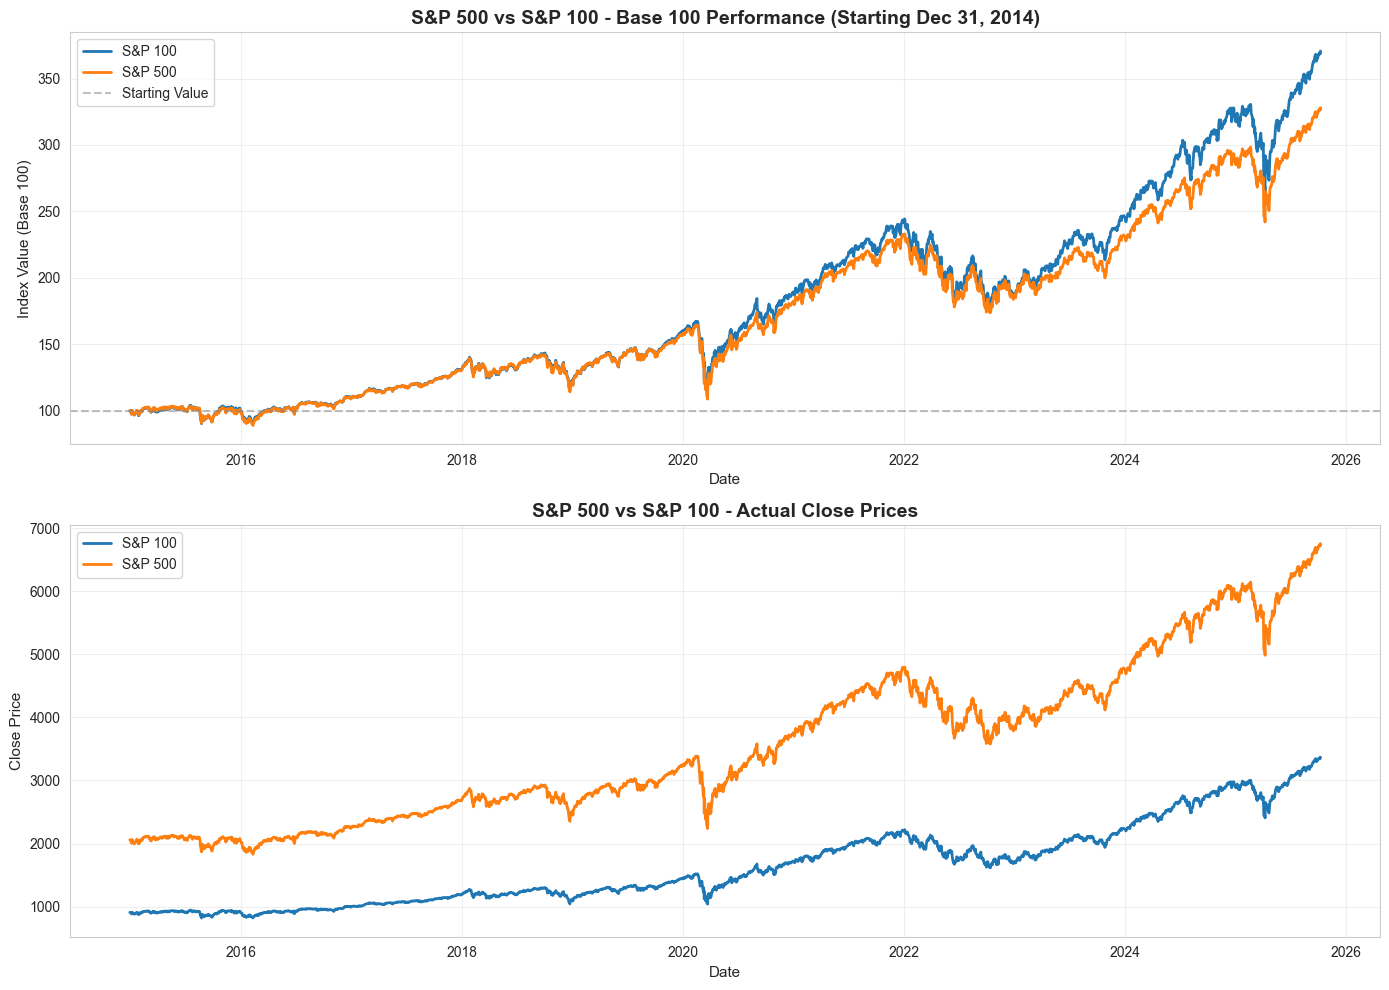


📊 Index Comparison Metrics:
   Daily return correlation: 0.9920
   (Perfect correlation = 1.0)


In [39]:
print("\n" + "="*70)
print("📈 VISUALIZING BASE 100 INDEX PERFORMANCE")
print("="*70)

if 'master_index_df' in locals():
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    sns.set_style("whitegrid")
    
    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Base 100 Normalized
    ax1 = axes[0]
    for index_name in master_index_df['index_name'].unique():
        idx_data = master_index_df[master_index_df['index_name'] == index_name]
        ax1.plot(idx_data['date'], idx_data['base_100'], label=index_name, linewidth=2)
    
    ax1.set_title('S&P 500 vs S&P 100 - Base 100 Performance (Starting Dec 31, 2014)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=11)
    ax1.set_ylabel('Index Value (Base 100)', fontsize=11)
    ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Starting Value')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Actual Close Prices
    ax2 = axes[1]
    for index_name in master_index_df['index_name'].unique():
        idx_data = master_index_df[master_index_df['index_name'] == index_name]
        ax2.plot(idx_data['date'], idx_data['close'], label=index_name, linewidth=2)
    
    ax2.set_title('S&P 500 vs S&P 100 - Actual Close Prices', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Close Price', fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_file = PRICES_DIR / 'index_base100_comparison.png'
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print(f"✅ Chart saved to: {plot_file.name}")
    
    plt.show()
    
    # Calculate and display correlation
    print(f"\n📊 Index Comparison Metrics:")
    
    sp500_data = master_index_df[master_index_df['index_name'] == 'S&P 500'].set_index('date')
    sp100_data = master_index_df[master_index_df['index_name'] == 'S&P 100'].set_index('date')
    
    # Merge on date for correlation
    merged = sp500_data[['close']].join(sp100_data[['close']], lsuffix='_sp500', rsuffix='_sp100')
    merged['return_sp500'] = merged['close_sp500'].pct_change()
    merged['return_sp100'] = merged['close_sp100'].pct_change()
    
    correlation = merged['return_sp500'].corr(merged['return_sp100'])
    print(f"   Daily return correlation: {correlation:.4f}")
    print(f"   (Perfect correlation = 1.0)")
    
else:
    print("⚠️ No data available for visualization")

In [40]:
print("\n" + "="*70)
print("📊 CREATING WIDE FORMAT (OPTIONAL)")
print("="*70)

if 'master_index_df' in locals():
    # Pivot to wide format for close prices
    wide_close = master_index_df.pivot(index='date', columns='index_name', values='close')
    wide_close.columns.name = None
    wide_close = wide_close.reset_index()
    
    print("✅ Wide format (Close Prices):")
    print(f"   Columns: {list(wide_close.columns)}")
    display(wide_close.head(10))
    
    # Pivot to wide format for base 100
    wide_base100 = master_index_df.pivot(index='date', columns='index_name', values='base_100')
    wide_base100.columns.name = None
    wide_base100 = wide_base100.reset_index()
    
    # Rename columns to be more descriptive
    wide_base100.columns = ['date'] + [f'{col}_base100' for col in wide_base100.columns if col != 'date']
    
    print("\n✅ Wide format (Base 100):")
    print(f"   Columns: {list(wide_base100.columns)}")
    display(wide_base100.head(10))
    
    # Save wide formats
    wide_close_file = PRICES_DIR / 'index_prices_wide_close.csv'
    wide_close.to_csv(wide_close_file, index=False)
    print(f"\n💾 Wide format (close) saved to: {wide_close_file.name}")
    
    wide_base100_file = PRICES_DIR / 'index_prices_wide_base100.csv'
    wide_base100.to_csv(wide_base100_file, index=False)
    print(f"💾 Wide format (base100) saved to: {wide_base100_file.name}")


📊 CREATING WIDE FORMAT (OPTIONAL)
✅ Wide format (Close Prices):
   Columns: ['date', 'S&P 100', 'S&P 500']


,date,S&P 100,S&P 500
0,2014-12-31 00:00:00-05:00,908.380005,2058.899902
1,2015-01-02 00:00:00-05:00,907.500000,2058.199951
2,2015-01-05 00:00:00-05:00,891.039978,2020.579956
3,2015-01-06 00:00:00-05:00,883.960022,2002.609985
4,2015-01-07 00:00:00-05:00,893.599976,2025.900024
5,2015-01-08 00:00:00-05:00,909.869995,2062.139893
6,2015-01-09 00:00:00-05:00,902.130005,2044.810059
7,2015-01-12 00:00:00-05:00,895.239990,2028.260010
8,2015-01-13 00:00:00-05:00,892.929993,2023.030029
9,2015-01-14 00:00:00-05:00,887.359985,2011.270020



✅ Wide format (Base 100):
   Columns: ['date', 'S&P 100_base100', 'S&P 500_base100']


,date,S&P 100_base100,S&P 500_base100
0,2014-12-31 00:00:00-05:00,100.000000,100.000000
1,2015-01-02 00:00:00-05:00,99.903124,99.966004
2,2015-01-05 00:00:00-05:00,98.091104,98.138815
3,2015-01-06 00:00:00-05:00,97.311700,97.266020
4,2015-01-07 00:00:00-05:00,98.372924,98.397208
5,2015-01-08 00:00:00-05:00,100.164027,100.157365
6,2015-01-09 00:00:00-05:00,99.311962,99.315662
7,2015-01-12 00:00:00-05:00,98.553467,98.511832
8,2015-01-13 00:00:00-05:00,98.299169,98.257814
9,2015-01-14 00:00:00-05:00,97.685988,97.686634



💾 Wide format (close) saved to: index_prices_wide_close.csv
💾 Wide format (base100) saved to: index_prices_wide_base100.csv


In [41]:
print("="*70)
print("📊 FETCHING VALUATION METRICS FOR ALL TICKERS")
print("="*70)

# We'll fetch only valuation/financial metrics, not sector (we already have that!)
print(f"\n⚙️ Configuration:")
print(f"  Total tickers to fetch: {len(ticker_universe)}")
print(f"  Data source: Yahoo Finance (.info attribute)")
print(f"  Note: Sector/industry already available from EODHD data ✅")

# Define ONLY valuation and financial metrics we want
VALUATION_FIELDS = [
    # Identifiers
    'symbol',
    'shortName',
    'longName',
    
    # Valuation metrics
    'marketCap',
    'enterpriseValue',
    'trailingPE',
    'forwardPE',
    'priceToBook',
    'priceToSalesTrailing12Months',
    'enterpriseToRevenue',
    'enterpriseToEbitda',
    'pegRatio',
    
    # Profitability
    'profitMargins',
    'operatingMargins',
    'returnOnAssets',
    'returnOnEquity',
    
    # Growth
    'revenueGrowth',
    'earningsGrowth',
    'earningsQuarterlyGrowth',
    
    # Dividends
    'dividendRate',
    'dividendYield',
    'payoutRatio',
    'fiveYearAvgDividendYield',
    'trailingAnnualDividendRate',
    'trailingAnnualDividendYield',
    
    # Risk metrics
    'beta',
    'fiftyTwoWeekLow',
    'fiftyTwoWeekHigh',
    'fiftyDayAverage',
    'twoHundredDayAverage',
    
    # Trading metrics
    'currentPrice',
    'previousClose',
    'regularMarketPreviousClose',
    'volume',
    'averageVolume',
    'averageVolume10days',
    
    # Size
    'sharesOutstanding',
    'floatShares',
    
    # Other useful info
    'currency',
    'exchange',
    'quoteType'
]

print(f"  Valuation fields to extract: {len(VALUATION_FIELDS)}")
print(f"\n📋 Key metrics: marketCap, P/E ratios, P/B, beta, dividend yield, etc.")

📊 FETCHING VALUATION METRICS FOR ALL TICKERS

⚙️ Configuration:
  Total tickers to fetch: 794
  Data source: Yahoo Finance (.info attribute)
  Note: Sector/industry already available from EODHD data ✅
  Valuation fields to extract: 41

📋 Key metrics: marketCap, P/E ratios, P/B, beta, dividend yield, etc.


In [42]:
def fetch_ticker_valuation(ticker):
    """
    Fetch valuation metrics for a single ticker.
    
    Args:
        ticker: Stock ticker symbol
        
    Returns:
        dict: Valuation data or None if failed
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Extract only valuation fields
        valuation = {'ticker': ticker}
        
        for field in VALUATION_FIELDS:
            valuation[field] = info.get(field, None)
        
        # Add timestamp
        valuation['data_fetched_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        return valuation
        
    except Exception as e:
        return {'ticker': ticker, 'error': str(e)}

def fetch_valuation_batch(tickers, batch_size=50, sleep_time=1):
    """
    Fetch valuation metrics for multiple tickers with progress tracking.
    
    Args:
        tickers: List of ticker symbols
        batch_size: Process this many at once before sleeping
        sleep_time: Seconds to wait between batches
        
    Returns:
        tuple: (successful_data, failed_tickers)
    """
    successful_data = []
    failed_tickers = []
    
    print(f"📥 Fetching valuation metrics for {len(tickers)} tickers...")
    print(f"   Batch size: {batch_size}, Sleep time: {sleep_time}s")
    print(f"   Estimated time: {len(tickers) * 0.5 / 60:.1f} minutes\n")
    
    # Process with progress bar
    for i in tqdm(range(len(tickers)), desc="Fetching"):
        ticker = tickers[i]
        
        # Fetch data
        data = fetch_ticker_valuation(ticker)
        
        if data and 'error' not in data:
            successful_data.append(data)
        else:
            failed_tickers.append({
                'ticker': ticker,
                'error': data.get('error', 'Unknown error') if data else 'No data returned'
            })
        
        # Rate limiting
        if (i + 1) % batch_size == 0 and i + 1 < len(tickers):
            time.sleep(sleep_time)
    
    print(f"\n✅ Successfully fetched: {len(successful_data)} tickers")
    print(f"❌ Failed: {len(failed_tickers)} tickers")
    
    return successful_data, failed_tickers

print("✅ Functions defined: fetch_ticker_valuation(), fetch_valuation_batch()")

✅ Functions defined: fetch_ticker_valuation(), fetch_valuation_batch()


In [43]:
print("="*70)
print("🚀 STARTING VALUATION DATA DOWNLOAD")
print("="*70)
print(f"\n☕ This will take approximately {len(ticker_universe) * 0.5 / 60:.1f} minutes...")
print("☕ Time for a quick coffee!\n")

# Start fetching
start_time = time.time()

valuation_data, failed_valuation = fetch_valuation_batch(
    tickers=ticker_universe,
    batch_size=50,
    sleep_time=1
)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"\n⏱️ Download completed in {elapsed_minutes:.1f} minutes")
print(f"⚡ Average: {len(ticker_universe) / (end_time - start_time):.1f} tickers/second")

🚀 STARTING VALUATION DATA DOWNLOAD

☕ This will take approximately 6.6 minutes...
☕ Time for a quick coffee!

📥 Fetching valuation metrics for 794 tickers...
   Batch size: 50, Sleep time: 1s
   Estimated time: 6.6 minutes



Fetching: 100%|██████████| 794/794 [04:49<00:00,  2.74it/s]


✅ Successfully fetched: 794 tickers
❌ Failed: 0 tickers

⏱️ Download completed in 4.8 minutes
⚡ Average: 2.7 tickers/second


In [44]:
print("\n" + "="*70)
print("📊 VALUATION DATA ANALYSIS")
print("="*70)

if valuation_data:
    # Convert to DataFrame
    valuation_df = pd.DataFrame(valuation_data)
    
    print(f"\n✅ Successfully fetched: {len(valuation_df)} tickers")
    print(f"❌ Failed: {len(failed_valuation)} tickers")
    print(f"📈 Success rate: {len(valuation_df)/(len(valuation_df)+len(failed_valuation))*100:.1f}%")
    
    # Show data completeness for key valuation fields
    print(f"\n📊 Data Completeness (% of tickers with data):")
    key_valuation_fields = [
        'marketCap', 'trailingPE', 'forwardPE', 'priceToBook', 
        'beta', 'dividendYield', 'profitMargins', 'returnOnEquity',
        'revenueGrowth', 'earningsGrowth'
    ]
    
    completeness = []
    for field in key_valuation_fields:
        if field in valuation_df.columns:
            non_null = valuation_df[field].notna().sum()
            pct = (non_null / len(valuation_df)) * 100
            completeness.append({
                'Metric': field, 
                'Available': non_null, 
                'Percentage': f"{pct:.1f}%"
            })
    
    completeness_df = pd.DataFrame(completeness)
    display(completeness_df)
    
    # Show sample
    print(f"\n📋 Sample of valuation data (first 10 tickers):")
    sample_cols = ['ticker', 'shortName', 'marketCap', 'trailingPE', 'priceToBook', 
                   'beta', 'dividendYield', 'profitMargins']
    available_cols = [col for col in sample_cols if col in valuation_df.columns]
    display(valuation_df[available_cols].head(10))
    
    # Key statistics
    print(f"\n📊 Key Valuation Statistics:")
    
    if 'marketCap' in valuation_df.columns:
        total_mcap = valuation_df['marketCap'].sum()
        avg_mcap = valuation_df['marketCap'].mean()
        median_mcap = valuation_df['marketCap'].median()
        print(f"   Total market cap: ${total_mcap/1e12:.2f} Trillion")
        print(f"   Average market cap: ${avg_mcap/1e9:.2f} Billion")
        print(f"   Median market cap: ${median_mcap/1e9:.2f} Billion")
    
    if 'trailingPE' in valuation_df.columns:
        # Filter reasonable P/E values
        pe_valid = valuation_df['trailingPE'][(valuation_df['trailingPE'] > 0) & 
                                               (valuation_df['trailingPE'] < 100)]
        if len(pe_valid) > 0:
            print(f"   Average P/E ratio: {pe_valid.mean():.2f}")
            print(f"   Median P/E ratio: {pe_valid.median():.2f}")
    
    if 'beta' in valuation_df.columns:
        beta_valid = valuation_df['beta'][valuation_df['beta'].notna()]
        if len(beta_valid) > 0:
            print(f"   Average beta: {beta_valid.mean():.2f}")
            print(f"   Median beta: {beta_valid.median():.2f}")
    
    if 'dividendYield' in valuation_df.columns:
        div_payers = valuation_df['dividendYield'][valuation_df['dividendYield'] > 0]
        if len(div_payers) > 0:
            print(f"   Dividend payers: {len(div_payers)} ({len(div_payers)/len(valuation_df)*100:.1f}%)")
            print(f"   Average dividend yield: {div_payers.mean()*100:.2f}%")

else:
    print("⚠️ No valuation data fetched")


📊 VALUATION DATA ANALYSIS

✅ Successfully fetched: 794 tickers
❌ Failed: 0 tickers
📈 Success rate: 100.0%

📊 Data Completeness (% of tickers with data):


,Metric,Available,Percentage
0,marketCap,640,80.6%
1,trailingPE,578,72.8%
2,forwardPE,638,80.4%
3,priceToBook,640,80.6%
4,beta,635,80.0%
5,dividendYield,484,61.0%
6,profitMargins,640,80.6%
7,returnOnEquity,601,75.7%
8,revenueGrowth,637,80.2%
9,earningsGrowth,546,68.8%



📋 Sample of valuation data (first 10 tickers):


,ticker,shortName,marketCap,trailingPE,priceToBook,beta,dividendYield,profitMargins
0,A,"Agilent Technologies, Inc.",3.960075e+10,32.636680,6.218725,1.262,0.70,0.17973
1,AAL,"American Airlines Group, Inc.",7.620561e+09,13.749167,-1.969190,1.366,NaN,0.01045
2,AAP,Advance Auto Parts Inc.,3.052034e+09,NaN,1.385734,1.108,1.90,-0.04370
3,AAPL,Apple Inc.,3.759516e+12,38.500000,57.172190,1.094,0.40,0.24296
4,ABBV,AbbVie Inc.,4.098592e+11,110.480960,-2230.865200,0.507,2.84,0.06451
5,ABMD,None,NaN,NaN,NaN,NaN,NaN,NaN
6,ABNB,"Airbnb, Inc.",7.358766e+10,29.173544,9.467901,1.109,NaN,0.22668
7,ABT,Abbott Laboratories,2.318639e+11,16.694235,4.585413,0.696,1.76,0.32427
8,ACGL,Arch Capital Group Ltd.,3.457140e+10,9.579110,1.559218,0.451,NaN,0.19493
9,ACN,Accenture plc,1.572167e+11,20.820427,5.039778,1.278,2.58,0.11021



📊 Key Valuation Statistics:
   Total market cap: $64.70 Trillion
   Average market cap: $101.09 Billion
   Median market cap: $27.12 Billion
   Average P/E ratio: 26.88
   Median P/E ratio: 23.16
   Average beta: 1.07
   Median beta: 1.04
   Dividend payers: 484 (61.0%)
   Average dividend yield: 238.24%


In [45]:
print("\n" + "="*70)
print("💾 SAVING VALUATION DATA")
print("="*70)

if 'valuation_df' in locals() and len(valuation_df) > 0:
    
    # Clean up - remove completely empty columns
    print("\n🧹 Cleaning data...")
    
    non_null_counts = valuation_df.notna().sum()
    cols_to_keep = non_null_counts[non_null_counts > 0].index.tolist()
    valuation_clean = valuation_df[cols_to_keep].copy()
    
    print(f"   Kept {len(cols_to_keep)} columns with data")
    print(f"   Removed {len(valuation_df.columns) - len(cols_to_keep)} empty columns")
    
    # Sort by ticker
    valuation_clean = valuation_clean.sort_values('ticker')
    
    # Save to CSV
    print(f"\n💾 Saving to CSV...")
    valuation_csv = FUNDAMENTALS_DIR / 'stock_valuation_metrics.csv'
    valuation_clean.to_csv(valuation_csv, index=False)
    
    csv_size_kb = valuation_csv.stat().st_size / 1024
    print(f"✅ Saved to: {valuation_csv.name}")
    print(f"   Rows: {len(valuation_clean):,}")
    print(f"   Columns: {len(valuation_clean.columns)}")
    print(f"   File size: {csv_size_kb:.2f} KB")
    
    # Save to Parquet
    print(f"\n💾 Saving to Parquet...")
    valuation_parquet = FUNDAMENTALS_DIR / 'stock_valuation_metrics.parquet'
    valuation_clean.to_parquet(valuation_parquet, index=False, engine='pyarrow')
    
    parquet_size_kb = valuation_parquet.stat().st_size / 1024
    print(f"✅ Saved to: {valuation_parquet.name}")
    print(f"   File size: {parquet_size_kb:.2f} KB")
    
    # Save failed tickers
    if failed_valuation:
        print(f"\n💾 Saving failed tickers...")
        failed_df = pd.DataFrame(failed_valuation)
        failed_file = FUNDAMENTALS_DIR / 'failed_valuation.csv'
        failed_df.to_csv(failed_file, index=False)
        print(f"✅ Saved to: {failed_file.name} ({len(failed_df)} tickers)")
    
    print(f"\n🎉 Valuation data saved successfully!")

else:
    print("⚠️ No valuation data to save")


💾 SAVING VALUATION DATA

🧹 Cleaning data...
   Kept 42 columns with data
   Removed 1 empty columns

💾 Saving to CSV...
✅ Saved to: stock_valuation_metrics.csv
   Rows: 794
   Columns: 42
   File size: 239.66 KB

💾 Saving to Parquet...
✅ Saved to: stock_valuation_metrics.parquet
   File size: 207.42 KB

🎉 Valuation data saved successfully!
